## NBA Position Predictor Project

### Created 16 November 2021

## Creating a Model

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from get_stats import *

In [2]:
data = get_full_dataframe()

In [3]:
stats_df = data
[(i, list(set(stats_df[stats_df['Year'] == i]['POS']))) for i in range(2017, 2022)]  # test

[(2017, ['G', 'SF', 'PF', 'SG', 'C', 'PG']),
 (2018, ['G', 'F-G', 'F', 'C-F', 'C', 'G-F', 'F-C']),
 (2019, ['G', 'F-G', 'F', 'C-F', 'C', 'G-F', 'F-C']),
 (2020, ['G', 'F-G', 'F', 'C-F', 'C', 'G-F', 'F-C']),
 (2021, ['G', 'F-G', 'F', 'C-F', 'C', 'G-F', 'F-C'])]

In [4]:
stats_df = stats_df[stats_df['Year'] != 2017].copy()
stats_df

,RANK,NAME,TEAM,POS,AGE,GP,MPG,MIN%,USG%,TO%,...,TRB%,APG,AST%,SPG,BPG,TOPG,VI,ORTG,DRTG,Year
209,NaN,Marc Gasol,Tor,C,34.37,24,30.6,63.8,13.6,9.5,...,11.5,3.0,14.7,0.88,1.08,0.88,7.4,118.4,97.2,2018
210,NaN,Danny Green,Tor,G-F,31.98,24,28.5,59.4,12.6,13.6,...,7.0,1.1,5.4,1.29,0.46,1.08,4.2,97.4,101.6,2018
211,NaN,Serge Ibaka,Tor,F-C,29.74,24,20.8,43.4,21.4,10.6,...,15.8,0.9,7.4,0.46,0.96,1.04,7.1,105.5,91.9,2018
212,NaN,Kawhi Leonard,Tor,F,27.96,24,39.1,81.6,32.0,11.1,...,12.8,3.9,19.3,1.67,0.71,3.08,10.5,118.9,102.7,2018
213,NaN,Kyle Lowry,Tor,G,33.22,24,37.5,78.2,18.4,14.5,...,7.2,6.6,27.5,1.29,0.29,2.21,8.4,116.8,100.1,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1567,NaN,Omer Yurtseven,Mia,C,23.74,49,12.8,26.6,20.2,13.3,...,23.8,0.9,11.9,0.31,0.39,0.78,9.5,114.6,92.9,2021
1568,NaN,Cody Zeller,Por,F-C,29.44,27,13.1,27.4,16.0,14.6,...,19.2,0.8,9.4,0.30,0.22,0.70,8.2,128.8,100.0,2021
1569,NaN,Ivica Zubac,Lac,C,25.00,65,24.7,51.4,16.6,16.9,...,17.9,1.5,9.2,0.51,1.05,1.58,8.3,126.7,99.3,2021
1570,NaN,Tyrone Wallace,Nor,G,27.77,2,17.9,37.3,13.5,0.0,...,6.2,0.0,0.0,0.00,0.50,0.00,0.0,90.3,106.7,2021


In [5]:
# replace positions to get two different player classifications:
pos_encode = {"G":0 , "F":1, "C":2, "GF":3, "FC":4}
## pos_encode = {"PG":0 , "SF":1, "C":2, "SG":3, "PF":4, "G":5 , "F":6}
pos_decode = {0:"G", 1:"F", 2:"C", 3:"GF", 4:"FC"}
## pos_decode = {0:"PG", 1:"SF", 2:"C", 3:"SG", 4:"PF"}

# - POS3 = {"G", "F", "C"}  # - POS5 = {"G", "GF", "F", "FC", "C"}
stats_df.loc[:, "POS3"] = stats_df["POS"].replace("G-F", "G").replace("F-G", "F").replace("C-F", "C").replace("F-C", "F")
## stats_df.loc[:, "POS3"] = stats_df["POS3"].replace("PG", "G").replace("SG", "G").replace("SF", "F").replace("PF", "F")
stats_df.loc[:, "POS5"] = stats_df["POS"].replace("G-F", "GF").replace("F-G", "GF").replace("C-F", "FC").replace("F-C", "FC")
## stats_df.loc[:, "POS5"] = stats_df["POS"].replace("G-F", "SG").replace("F-G", "SG").replace("C-F", "PF").replace("F-C", "PF")
## stats_df.loc[:, "POS5"] = stats_df["POS5"].replace("G", "PG").replace("F", "SF")
stats_df

,RANK,NAME,TEAM,POS,AGE,GP,MPG,MIN%,USG%,TO%,...,AST%,SPG,BPG,TOPG,VI,ORTG,DRTG,Year,POS3,POS5
209,NaN,Marc Gasol,Tor,C,34.37,24,30.6,63.8,13.6,9.5,...,14.7,0.88,1.08,0.88,7.4,118.4,97.2,2018,C,C
210,NaN,Danny Green,Tor,G-F,31.98,24,28.5,59.4,12.6,13.6,...,5.4,1.29,0.46,1.08,4.2,97.4,101.6,2018,G,GF
211,NaN,Serge Ibaka,Tor,F-C,29.74,24,20.8,43.4,21.4,10.6,...,7.4,0.46,0.96,1.04,7.1,105.5,91.9,2018,F,FC
212,NaN,Kawhi Leonard,Tor,F,27.96,24,39.1,81.6,32.0,11.1,...,19.3,1.67,0.71,3.08,10.5,118.9,102.7,2018,F,F
213,NaN,Kyle Lowry,Tor,G,33.22,24,37.5,78.2,18.4,14.5,...,27.5,1.29,0.29,2.21,8.4,116.8,100.1,2018,G,G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1567,NaN,Omer Yurtseven,Mia,C,23.74,49,12.8,26.6,20.2,13.3,...,11.9,0.31,0.39,0.78,9.5,114.6,92.9,2021,C,C
1568,NaN,Cody Zeller,Por,F-C,29.44,27,13.1,27.4,16.0,14.6,...,9.4,0.30,0.22,0.70,8.2,128.8,100.0,2021,F,FC
1569,NaN,Ivica Zubac,Lac,C,25.00,65,24.7,51.4,16.6,16.9,...,9.2,0.51,1.05,1.58,8.3,126.7,99.3,2021,C,C
1570,NaN,Tyrone Wallace,Nor,G,27.77,2,17.9,37.3,13.5,0.0,...,0.0,0.00,0.50,0.00,0.0,90.3,106.7,2021,G,G


In [6]:
print(stats_df.groupby('POS3')['POS3'].count())
print(stats_df.groupby('POS5')['POS5'].count())

POS3
C    143
F    479
G    582
Name: POS3, dtype: int64
POS5
C      97
F     345
FC    130
G     473
GF    159
Name: POS5, dtype: int64


In [7]:
stats_df.describe()

,RANK,AGE,GP,MPG,MIN%,USG%,TO%,FTA,FT%,2PA,...,TRB%,APG,AST%,SPG,BPG,TOPG,VI,ORTG,DRTG,Year
count,0.0,1204.000000,1204.000000,1204.000000,1204.000000,1204.000000,1204.000000,1204.000000,1204.000000,1204.000000,...,1204.000000,1204.000000,1204.000000,1204.000000,1204.000000,1204.000000,1204.000000,1204.000000,1204.000000,1204.000000
mean,NaN,27.263098,22.132060,20.699086,43.116445,18.549751,11.772841,46.855482,0.682197,112.055648,...,10.115116,1.966694,13.109718,0.618978,0.392542,1.097741,6.500166,108.497259,104.205565,2020.065615
std,NaN,4.185757,20.769206,10.311067,21.483654,6.227288,6.641676,73.209074,0.273329,159.839210,...,5.181873,1.984930,10.097444,0.467155,0.421823,0.936020,2.833126,21.422068,6.378397,1.136494
min,NaN,19.230000,1.000000,4.000000,8.300000,4.300000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,69.200000,2018.000000
25%,NaN,23.922500,5.000000,11.675000,24.350000,14.200000,8.100000,5.000000,0.611750,13.000000,...,6.400000,0.600000,6.500000,0.270000,0.110000,0.450000,5.100000,100.475000,100.800000,2019.000000
50%,NaN,26.965000,12.000000,20.050000,41.700000,17.600000,11.200000,18.000000,0.759500,44.000000,...,8.950000,1.300000,10.250000,0.535000,0.275000,0.830000,6.500000,110.300000,104.600000,2021.000000
75%,NaN,30.170000,40.000000,29.600000,61.700000,22.200000,14.700000,56.000000,0.850000,142.000000,...,13.000000,2.600000,17.800000,0.900000,0.530000,1.500000,8.100000,118.700000,108.500000,2021.000000
max,NaN,41.770000,70.000000,41.300000,86.100000,48.300000,50.000000,666.000000,1.000000,1179.000000,...,44.100000,11.800000,76.900000,2.800000,4.000000,5.170000,17.400000,280.100000,121.500000,2021.000000


In [8]:
stats_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1204 entries, 209 to 1571
Data columns (total 32 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RANK    0 non-null      float64
 1   NAME    1204 non-null   object 
 2   TEAM    1204 non-null   object 
 3   POS     1204 non-null   object 
 4   AGE     1204 non-null   float64
 5   GP      1204 non-null   int64  
 6   MPG     1204 non-null   float64
 7   MIN%    1204 non-null   float64
 8   USG%    1204 non-null   float64
 9   TO%     1204 non-null   float64
 10  FTA     1204 non-null   int64  
 11  FT%     1204 non-null   float64
 12  2PA     1204 non-null   int64  
 13  2P%     1204 non-null   float64
 14  3PA     1204 non-null   int64  
 15  3P%     1204 non-null   float64
 16  eFG%    1204 non-null   float64
 17  TS%     1204 non-null   float64
 18  PPG     1204 non-null   float64
 19  RPG     1204 non-null   float64
 20  TRB%    1204 non-null   float64
 21  APG     1204 non-null   float64
 22

### k-Nearest Neighbor Classification

In [9]:
#divide the data into the input 'X' and the labels 'y'
# all features: ['AGE', 'GP', 'MPG', 'MIN%', 'USG%', 'TO%', 'FTA', 'FT%', '2PA', '2P%', '3PA', '3P%', 'eFG%', 'TS%', 'PPG', 'RPG', 'TRB%', 'APG', 'AST%', 'SPG', 'BPG', 'TOPG', 'VI', 'ORTG', 'DRTG']
selected_features = [i for i in list(stats_df)[4:-3]]  # if i not in ['MPG', 'PPG']]
X        = stats_df[selected_features] #the observations
y        = stats_df['POS3'] #the label

In [10]:
def kNearest(i, X_train, X_test, y_train, y_test):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    return (i, knn.score(X_test, y_test) * 100) # The accuracy of the model

def kNN_Model(X, y, display=False, report=False):
    """Return the optimal value of k and the max accuracy"""
    # split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=6, stratify = y)
    # Enter appropriate values to partition data, and ensure results are reproducible and obtain stratified samples
    
    # feature scaling
    sc = StandardScaler()
    sc.fit(X_train)
    X_train_std, X_test_std = sc.transform(X_train), sc.transform(X_test)    
    
    # build the k-nn model, experiment with different values of k
    accuracy_scores = [ kNearest(i, X_train_std, X_test_std, y_train, y_test) for i in range(1,30)]
    max_accuracy = max([e[1] for e in accuracy_scores])
    
    best = [t for t in accuracy_scores if t[1] == max_accuracy]
    best = min([x[0] for x in best])
    acc = pd.DataFrame({'k': [e[0] for e in accuracy_scores], 'accuracy': [e[1] for e in accuracy_scores]})
    
    # plot the results
    if display:
        lines = acc.plot.line(x = 'k')
    
    knn = KNeighborsClassifier(n_neighbors=best) 
    knn.fit(X_train_std, y_train)
    y_pred=knn.predict(X_test_std)
    
    # show the results
    if report:
        print(classification_report(y_test, y_pred))
    return best, max_accuracy

#### Feature Selection

In [11]:
all_feature_accuracy = kNN_Model(X, stats_df['POS3'])[1]
all_but_one_feat = [(feat, [f for f in list(stats_df)[4:-3] if f != feat]) for feat in list(stats_df)[4:-3]]
importance = [(feat, kNN_Model(stats_df[feat_lis], stats_df['POS3'])[1]) for feat, feat_lis in all_but_one_feat]

importance = sorted(importance, key = lambda x: x[1], reverse=True)
print(f"The overall accuracy with all features is {all_feature_accuracy}")

print("\nThe overall accuracy increases by omitting the following features:")
omit3 = []
for feat, acc_without_feature in importance:
    if acc_without_feature > all_feature_accuracy:
        print(f"Accuracy without {feat} is {round(acc_without_feature, 4)}")
        omit3.append(feat)

The overall accuracy with all features is 70.44198895027624

The overall accuracy increases by omitting the following features:
Accuracy without AGE is 71.2707
Accuracy without TO% is 71.2707
Accuracy without FT% is 71.2707


              precision    recall  f1-score   support

           C       0.89      0.37      0.52        43
           F       0.65      0.67      0.66       144
           G       0.77      0.85      0.81       175

    accuracy                           0.72       362
   macro avg       0.77      0.63      0.66       362
weighted avg       0.73      0.72      0.72       362



(16, 72.37569060773481)

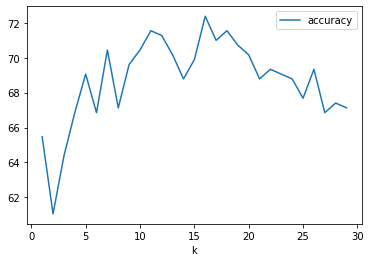

In [12]:
X2 = stats_df[[f for f in X if f not in omit3]]
kNN_Model(X2, stats_df['POS3'], display=True, report=True)

In [13]:
all_feature_accuracy = kNN_Model(X, stats_df['POS5'])[1]
all_but_one_feat = [(feat, [f for f in list(stats_df)[4:-3] if f != feat]) for feat in list(stats_df)[4:-3]]
importance = [(feat, kNN_Model(stats_df[feat_lis], stats_df['POS5'])[1]) for feat, feat_lis in all_but_one_feat]

importance = sorted(importance, key = lambda x: x[1], reverse=True)
print(f"The overall accuracy with all features is {all_feature_accuracy}")

print("\nThe overall accuracy increases by omitting the following features:")
omit5 = []
for feat, acc_without_feature in importance:
    if acc_without_feature > all_feature_accuracy:
        print(f"Accuracy without {feat} is {round(acc_without_feature, 4)}")
        omit5.append(feat)

The overall accuracy with all features is 53.03867403314917

The overall accuracy increases by omitting the following features:
Accuracy without AGE is 55.5249
Accuracy without 3PA is 55.2486
Accuracy without DRTG is 55.2486
Accuracy without 3P% is 54.4199
Accuracy without VI is 54.4199
Accuracy without ORTG is 54.1436
Accuracy without GP is 53.8674
Accuracy without SPG is 53.8674
Accuracy without 2PA is 53.3149
Accuracy without 2P% is 53.3149


              precision    recall  f1-score   support

           C       0.50      0.28      0.36        29
           F       0.49      0.68      0.57       104
          FC       0.18      0.05      0.08        39
           G       0.69      0.85      0.76       142
          GF       0.38      0.12      0.19        48

    accuracy                           0.57       362
   macro avg       0.45      0.40      0.39       362
weighted avg       0.52      0.57      0.52       362



(25, 57.182320441988956)

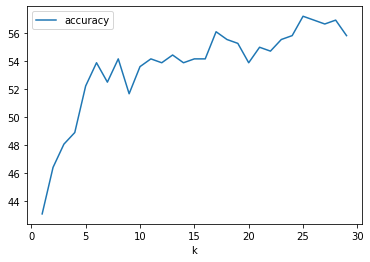

In [14]:
X2 = stats_df[[f for f in X if f not in omit5]]
kNN_Model(X2, stats_df['POS5'], display=True, report=True)